# Theory of Mind Planning

This notebook does some trial and error on planning with ToM

In [1]:
%load_ext autoreload
%autoreload 2

import sys

if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
np.random.seed(1)

## Environment

We setup a simple line enviroment. Both agents start in the center without knowing where the food is. We first spawn it at location 0.

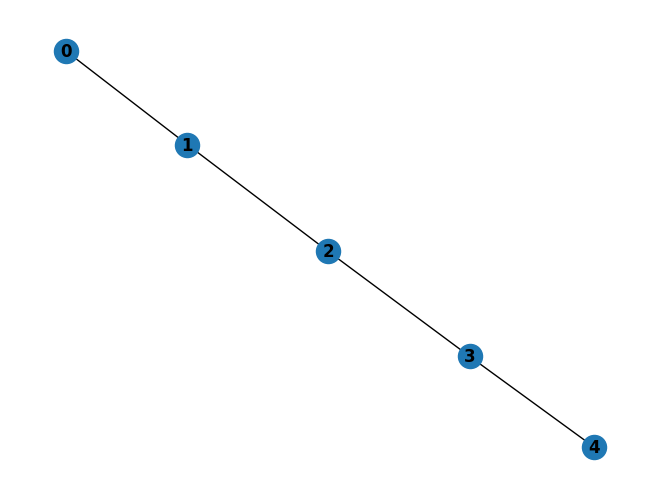

In [2]:
import util
import networkx as nx
from envs import GraphEnv

graph, metadata = util.generate_line(5)
nx.draw(graph, with_labels=True, font_weight="bold")

agent_config = {
        "Agent 1": 2,
        "Agent 2" : 2
    }
object_config = {"Food": 0}

# create environment
env = GraphEnv(graph, agent_config, object_config, forage=True)

## Agents

Now we create two `ForageAgent`s, and enable ToM

In [3]:
from agents import ForageAgent, ToMAgent

agents = [
    ForageAgent(
        a, env, [0], sophisticated=True, planning_horizon=3,
    )
    for a in agent_config.keys()
]

agents = [
    ToMAgent(
        a,
        others=[o for o in agents if o != a],
        self_states=[0],  # own location is "self" state
        observed_states=[0, 2],  # observe other location and energy state?
        shared_states=[1],  # object location is "shared" state
    )
    for a in agents
]

## Experiment


In [4]:
from experiment import tick

result = {a: [] for a in agent_config.keys()}

# simulate T timesteps

T = 10
for t in range(T):
    info = tick(agents, env)

    for agent, info in info.items():
        result[agent].append(info)

Agent 1 moved to location 1
Agent 2 moved to location 2
Agent 1 moved to location 0 and observed object
Agent 2 moved to location 3
Object consumed, respawned at location  4
Agent 2 moved to location 4 and observed object
Agent 1 eats
Object consumed, respawned at location  1
Agent 2 eats
Agent 1 moved to location 1 and observed object
Object consumed, respawned at location  4
Agent 2 moved to location 3
Agent 1 eats
Agent 2 moved to location 2
Agent 1 moved to location 2
Agent 1 moved to location 3
Agent 2 moved to location 1
Agent 1 moved to location 4 and observed object
Agent 2 moved to location 0
Object consumed, respawned at location  0
Agent 1 eats
Agent 2 moved to location 1
Agent 2 moved to location 0 and observed object
Agent 1 moved to location 3


In [5]:
from visualize import *

def policy_label(node):
    policy = node["policy"]
    if policy[0][-1] == 1:
        return "eat"
    elif policy[0][1] == 1:
        return "pick"
    elif policy[0][2] == 2:
        return "drop"
    else:
        return str(policy[0][0])


def observation_label(node):
    observation = node["observation"]
    res = ""
    for i, o in enumerate(observation):
        res += str(np.argmax(o)) + " "
    return res

Both agents search for food and share beliefs. Whenever food is found they eat it to avoid running out of energy.

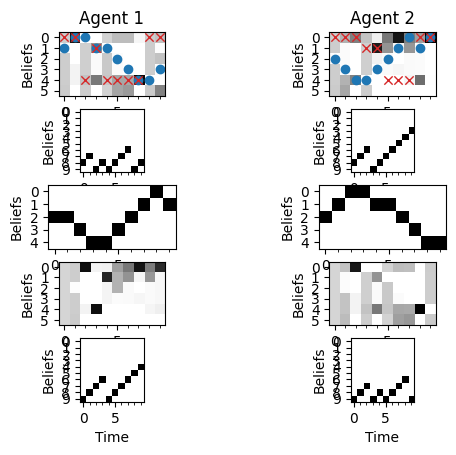

In [6]:
plot_beliefs(result)

What is more interesting is to look at the plan tree. Blue nodes are observations of the focal agent, red nodes are actions selected by the focal agents, green nodes are policies selected by the other agent, and purple nodes are observations likely observed by the other agent (under the focal agent's model).

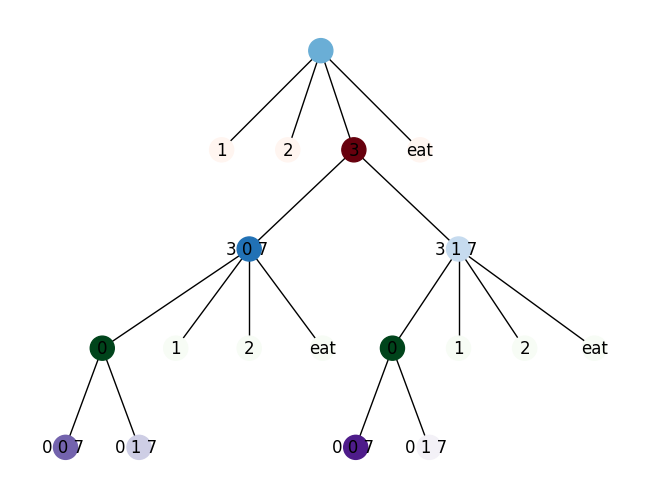

In [7]:
timestep = 1
plan_tree = result["Agent 2"][timestep]["tree"]
plot_plan_tree(plan_tree, policy_label, observation_label, depth=2)

Notice how the focal agent will search location 3, and expects the other agent to explore location 1. When the focal agent expects to find the object at location 3, it will expect the other _not_ to see the object at location 0, as depicted by the more intense purple of node 0 0 7 on the right branch.